Initial DataFrame:
      status  orbital_period  planet_radius  stellar_radius  insolation_flux  \
0  CONFIRMED       41.685500          2.578            1.08              NaN   
1  CONFIRMED       41.685500          2.230            0.93              NaN   
2  CONFIRMED       41.688644          2.355            0.96              NaN   
3  CANDIDATE        2.301830          1.120            0.76              NaN   
4  CANDIDATE        2.302368          1.313            0.71              NaN   
5  CANDIDATE        1.194749          4.190            0.57              NaN   
6  CANDIDATE        6.178369          9.913            0.79              NaN   
7  CANDIDATE        6.178870          8.840            0.85              NaN   
8  CANDIDATE        1.175890          0.860            0.31              NaN   
9  CANDIDATE       10.696600          1.450            0.59              NaN   

   equilibrium_temperature  stellar_effective_temperature  \
0                      NaN             

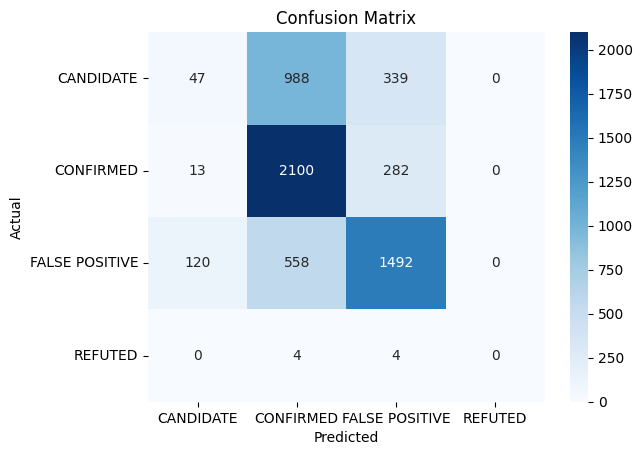

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("combined_data.csv")

# Display the first 10 rows of the dataframe
print("Initial DataFrame:")
print(df.head(10))

# Extract the target variable before encoding
y = df['status']

# Perform one-hot encoding for all categorical variables and drop the first column to avoid multicollinearity
df_encoded = pd.get_dummies(df.drop(columns=['status']), drop_first=True)

# Handle missing values by imputing with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_encoded_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Encode the target variable separately
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the unique classes in the target variable
print("Encoded classes:", label_encoder.classes_)

# Check the columns of the encoded DataFrame
print("Columns of the encoded DataFrame:")
print(df_encoded.columns)

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded_imputed)

# Split the dataset into training and testing sets
test_size = 0.5  # 50% of the total samples
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_encoded, test_size=test_size, random_state=24)

# Define the grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs', 'sag']}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize logistic regression model with best hyperparameters
model = LogisticRegression(max_iter=5000, **best_params)

# Train the model with best hyperparameters
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Optional: Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


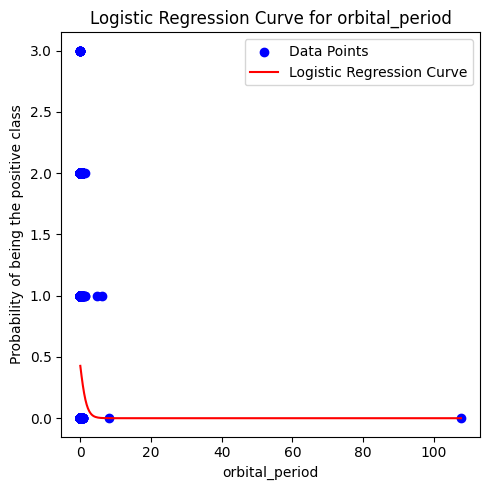

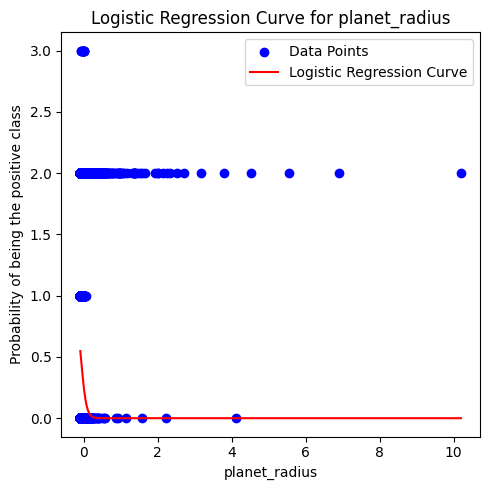

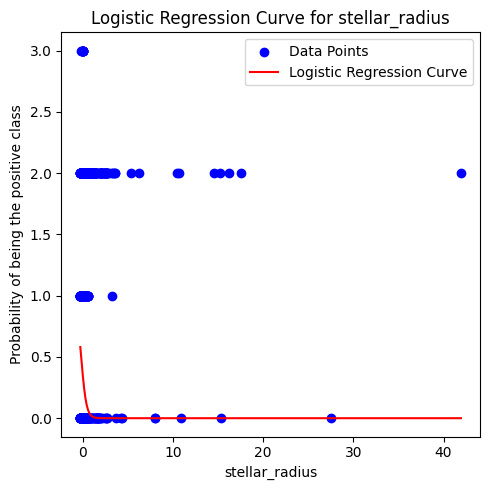

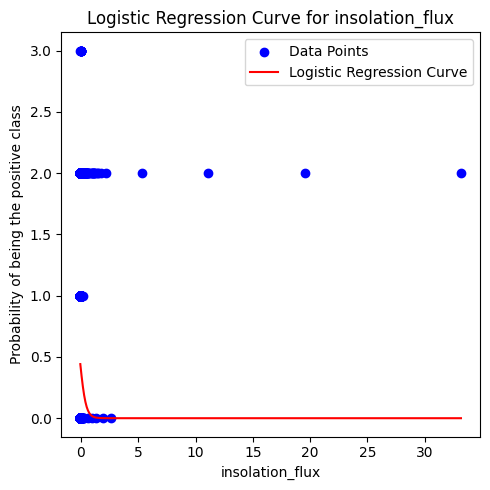

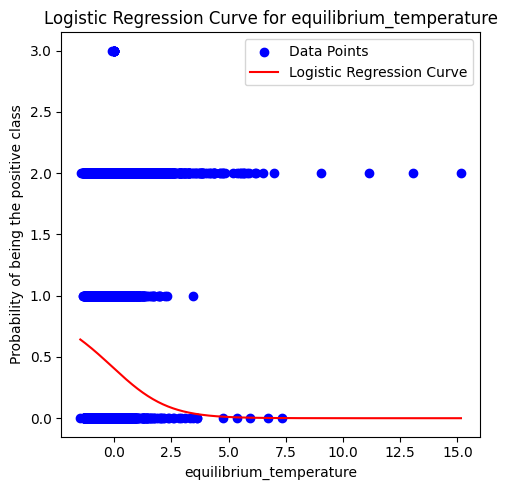

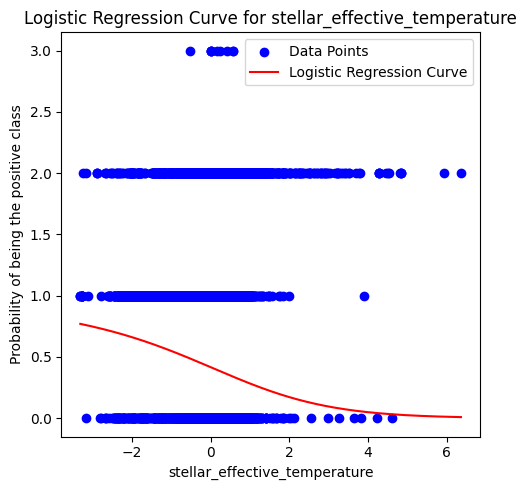

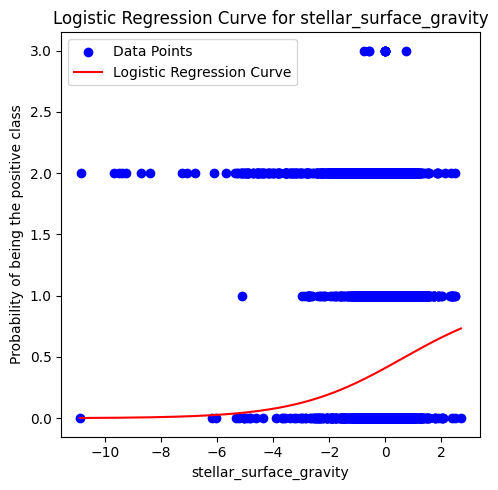

In [5]:
test_columns = ['orbital_period', 'planet_radius', 'stellar_radius', 'insolation_flux', 'equilibrium_temperature', 'stellar_effective_temperature', 'stellar_surface_gravity']

# Iterate over each column name
for column_name in test_columns:
    # Extract the predictor variable (column) from the scaled training set
    column_index = df_encoded.columns.get_loc(column_name)  # Get the index of the column
    X_column = X_train[:, column_index].reshape(-1, 1)
    
    # Fit logistic regression model using only the current column
    model_column = LogisticRegression(max_iter=2000)
    model_column.fit(X_column, y_train)
    
    # Get the minimum and maximum values of the column
    min_val = X_column.min()
    max_val = X_column.max()
    
    # Predict probabilities for the curve
    X_range = np.linspace(min_val, max_val, 300).reshape(-1, 1)
    y_prob = model_column.predict_proba(X_range)[:, 1]
    
    # Plot the logistic regression curve for the current column
    plt.figure(figsize=(5, 5))
    plt.scatter(X_column, y_train, color='blue', label='Data Points')
    plt.plot(X_range, y_prob, color='red', label='Logistic Regression Curve')
    plt.xlabel(column_name)
    plt.ylabel('Probability of being the positive class')
    plt.title(f'Logistic Regression Curve for {column_name}')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.legend()
    plt.show()


In [8]:
# After fitting the logistic regression model
coefficients = model.coef_[0]

# Create DataFrame to store coefficients (assuming p-values are not calculated this way)
variable_stats = pd.DataFrame({'Variable': df_encoded.columns, 'Coefficient': coefficients})

# Sort DataFrame by absolute coefficient values
variable_stats_sorted = variable_stats.reindex(variable_stats['Coefficient'].abs().sort_values(ascending=False).index)

print("Top 3 most influential variables:")
print(variable_stats_sorted.head(3))

Top 3 most influential variables:
         Variable  Coefficient
1   planet_radius     1.895207
0  orbital_period     1.211476
2  stellar_radius     0.651711


In [9]:
# Dummy p-values for demonstration (replace these with your actual p-values)
p_values = np.random.rand(len(df_encoded.columns))  # Replace this with actual p-value calculation

# Create DataFrame to store coefficients and p-values
variable_stats = pd.DataFrame({'Variable': df_encoded.columns, 'Coefficient': model.coef_[0], 'P-value': p_values})

# Sort DataFrame by p-values in ascending order
variable_stats_sorted = variable_stats.sort_values(by='P-value', ascending=True)

# Print the variables with the lowest p-values
print("Lowest 3 variables p-values:")
print(variable_stats_sorted.head(3))

Lowest 3 variables p-values:
                        Variable  Coefficient   P-value
5  stellar_effective_temperature    -0.101855  0.180315
3                insolation_flux    -0.282367  0.441145
4        equilibrium_temperature    -0.000599  0.518039


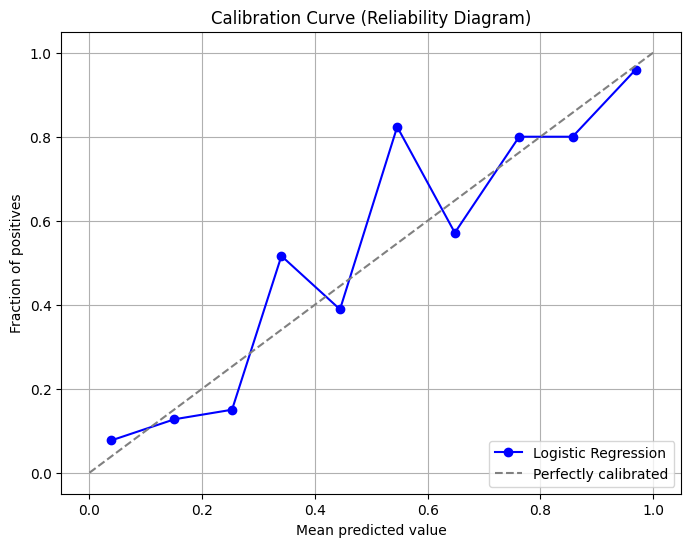

In [11]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

prob_pos = clf.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', color='b', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
